In [198]:
import numpy as np
import pandas as pd
from numba import njit, float64

from math import ceil, floor
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import qmc

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

from importlib import reload

# Question 4: Pricing 2 step Asian Options using Monte Carlo
Write a Monte Carlo simulation program that generates n = 106 samples1
(under the probability measure Q) of the payoff CT . The program should produce a Monte
Carlo estimate  ̄C0 of C0, the standard error in that estimate, and a 95% confidence interval
based on that standard error. Compare the result to the theoretical value you found in the
previous question

In [199]:
# Parameters
T       = 10 # Years
r       = -0.0027 #np.log(1-0.0027)
sigma   = 0.21
S       = K = 715

CI95 = norm.ppf(1-(.05/2)) ; print(f'CI95 = {CI95:.4f}')

CI95 = 1.9600


**Analytical Solutions to calculate the Discounted Expected Payoff of 2 step Asian Put (Geometric Mean). Where:**
$$
C_0 = e^{-rT}E^{Q}[(K - S_{0}exp\{aT+bdW_T\})^{+}]
$$

**Under Risk Neutral Probability**
$$
\begin{align*}
&a &=\;& \frac{1}{2}(r+\frac{1}{2}\sigma^2) \\
&b &=\;& \frac{1}{3}\sigma\sqrt{\frac{5}{2}} \\
\end{align*}
$$

**Calculating $C_0$ Analytically:**
$$
\begin{align*}
 & C_0 &=\;& e^{-rT}[K\Phi(d) - S_0\cdot exp\{aT+\frac{1}{2}b^2T\}\Phi(d-b\sqrt{T})] \\
 & d   &=\;& \frac{ln(K/S_0) - aT}{b\sqrt{T}}
\end{align*}
$$

In [200]:
def asian_2_step_put_analytical(S0, K, r, sigma, T):
    a = 0.5*(r-.5*sigma**2)
    b = 1/3*sigma*np.sqrt(5/2)

    d = (np.log(K/S0) - a*T) / (b*np.sqrt(T))

    P = np.exp(-r*T) * (K*norm.cdf(d) - S0*np.exp(a*T + 0.5* b**2 * T) * norm.cdf(d-b*np.sqrt(T)))
    return P
    

In [201]:
def asian_2_step_put_MC(S0, K, r, sigma, T, n_paths):
    dt = T/2
    # W: Weiner Process with iid Normal variables with std=sqrt(dt)
    np.random.seed(seed=1234)
    W       = np.random.normal(loc=0., scale=np.sqrt(dt), size=(n_paths,2) )
    
    S1 = S0 * np.exp((r-.5*sigma**2)*dt + sigma*W[:,0])
    S2 = S1 * np.exp((r-.5*sigma**2)*dt + sigma*W[:,1])
    HT = np.power(S0*S1*S2, 1/3)

    Payoffs = np.maximum(K - HT, 0) * np.exp(-r*T)
    P  = Payoffs.mean()  # Numerical Approximation of the Put's Value
    SE = Payoffs.std(ddof=1) / np.sqrt(n_paths) # Calculating Standard Error
    return P, SE
    
    
n_paths = 10**6

analytical_result           = asian_2_step_put_analytical(S, K, r, sigma, T)
numerical_approximation, SE = asian_2_step_put_MC(S, K, r, sigma, T, n_paths)

print(f'Analytical  = {asian_2_step_put_analytical(S, K, r, sigma, T):.3f} EUR')
print(f'Monte-Carlo = {numerical_approximation:.3f} EUR,  Number of paths = {n_paths:,}')
print(f'SE = {SE:.3f} EUR')
print(f'RE = {SE/numerical_approximation*100:.3f} %')
print(f'95% CI = [{numerical_approximation - SE*CI95:.3f} , {numerical_approximation + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo:')
%timeit asian_2_step_put_MC(S, K, r, sigma, T, n_paths)

Analytical  = 122.765 EUR
Monte-Carlo = 122.777 EUR,  Number of paths = 1,000,000
SE = 0.131 EUR
RE = 0.107 %
95% CI = [122.521 , 123.034]

Time to calculate put Value using Monte Carlo:
63.7 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Question 5: Asian Put
Write a Monte Carlo simulation program that generates n = 104 samples1
(under the probability measure Q) of the stock price path and the payoff GT . Use this to
generate a Monte Carlo estimate  ̄G0 of the price G0, the standard error in that estimate,
and a 95% confidence interval based on that standard error

## Asian Put with Trapezoidal Rule
We use the following algorithm to compute $I_T$ where:    
$$
\begin{align*}
& I_T &=\;& \int_0 ^TS_tdt \\
& I_T &\approx& \frac{1}{M}\sum_{i=0}^{M}\frac{S_i + S_{i+1}}{2}  \\
\end{align*}
$$
With $M=100$ (the number of time steps to simulate), $S_0=715$ and afterwards we simulate 100 steps. For a $S_t$ array of 101 values.

In [202]:
""" MC approximation of Asian """
def asian_put_MC(S0, K, r, sigma, T, N, M):
    dt      = T/M
    Payoffs = np.empty(shape=N)
    
    drift   = (r - 0.5*sigma**2)*dt
    volatil = sigma*np.sqrt(dt)
    np.random.seed(seed=1234)
    X       = np.append(np.zeros((N,1)), np.random.normal(loc=drift, scale=volatil, size=(N, M)), axis=1)

    # loop over paths
    for m in range(N):
        # Mean St Value
        St = S0 * np.exp(np.cumsum(X[m]))
        mean_St = np.mean((St[:-1] + St[1:])/2)
        # Payoff
        Payoffs[m] = np.maximum(K - mean_St, 0) * np.exp(-r*T)

    P  = Payoffs.mean()  # Numerical Approximation of the Put's Value
    SE = Payoffs.std() / np.sqrt(N) # Calculating Standard Error
    return P, SE, X


_n_paths    = 10**4 ;   M = 100
numerical_approximation, SE, X = asian_put_MC(S, K, r, sigma, T, _n_paths, M)

print(f'Monte-Carlo = {numerical_approximation:.3f} EUR,  Number of paths = {_n_paths:,}')
print(f'SE = {SE:.3f} EUR')
print(f'RE = {SE/numerical_approximation*100:.3f} %')
print(f'95% CI = [{numerical_approximation - SE*CI95:.3f} , {numerical_approximation + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

%timeit asian_put_MC(S, K, r, sigma, T, _n_paths, M)

Monte-Carlo = 115.621 EUR,  Number of paths = 10,000
SE = 1.291 EUR
RE = 1.117 %
95% CI = [113.090 , 118.152]

Time to calculate put Value using Monte Carlo
99.9 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# MC Paths of S(t) and Distribution of Payoff

Probability S(T) > K = 39.6 %
Expected Payoff             = 112.2615
Discounted Expected Payoff  = 115.3338


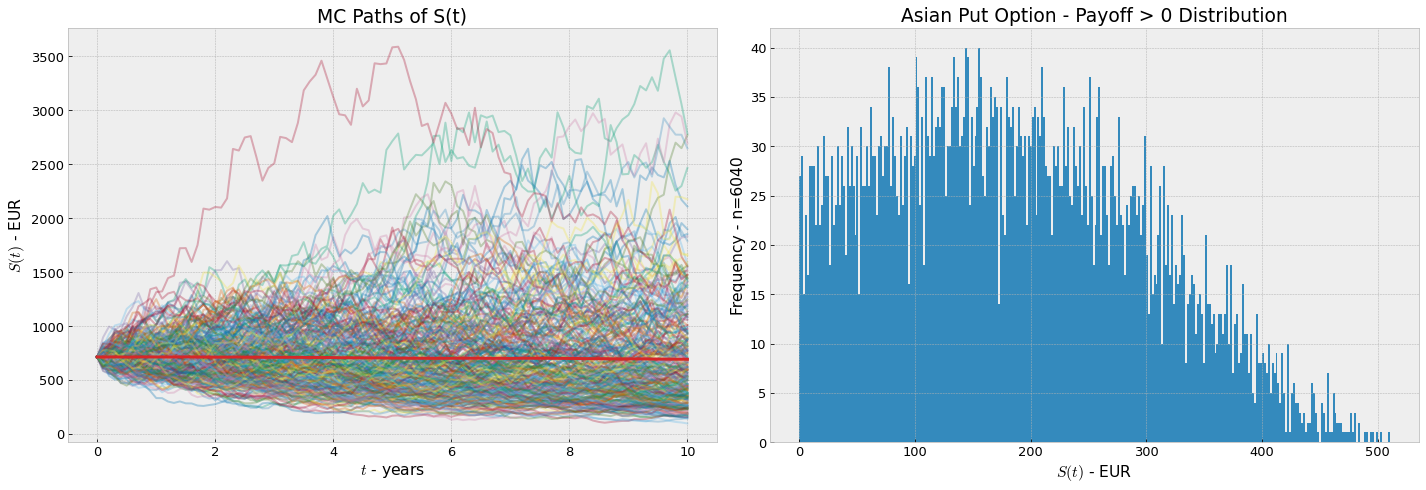

In [203]:
S_paths = S * np.exp(np.cumsum(X, axis=1))

fig, (ax1, ax2) = plt.subplots(ncols=2)

S_paths = pd.DataFrame(S_paths.T, index=np.linspace(0, T, M+1))
S_paths.sample(n=300, axis=1).plot(title='MC Paths of S(t)', ylabel=r'$S(t)$ - EUR', xlabel=r'$t$ - years', legend=False, alpha=.3, ax=ax1)
S_paths.mean(axis=1).plot(ax=ax1, color='tab:red', linewidth=3)

# Payoff Distribution
Payoff_df = np.maximum(K - S_paths.mean(axis=0), 0)
Payoff_df[Payoff_df>0].plot.hist(bins=300, ax=ax2, title='Asian Put Option - Payoff > 0 Distribution', xlabel=r'$S(t)$ - EUR')
ax2.set_xlabel(r'$S(t)$ - EUR')
ax2.set_ylabel(f'Frequency - n={Payoff_df[Payoff_df>0].shape[0]}')
plt.tight_layout()

print(f'Probability S(T) > K = {Payoff_df[Payoff_df==0].shape[0]/Payoff_df.shape[0]*100} %')
print(f'Expected Payoff             = {Payoff_df.mean():.4f}')
print(f'Discounted Expected Payoff  = {Payoff_df.mean()*np.exp(-r*T):.4f}')

# Question 6 - Control Variates in Pricing Asian Options
Repeat the calculation in 5. but this time use the payoffs CT in (1) as a control
variate: take the n = 104 samples of the stock price path you generated to define a new
estimator based on
Gnew
T = GT − βCT ,
and then add βC0 afterwards, as indicated in Lecture 4. To make an appropriate choice
for β, use your samples {(Gi
T , Ci
T ), i = 1...104}. Report the value, standard error, and the
95% confidence interval for  ̄Gnew
0 and compare your result to the values you found in 5

Using the 2 step Asian Put as a control variate for reducing the variance in the estimation of the value of an Asian Option.
$$
\begin{align*}
 & G_{new}  &=\;& G_0 - c*(C_0 - C_{Analytical}) \\
 &c         &=\;& \frac{Cov(G_0, C_0)}{Var(C_0)} \\
\end{align*}
$$
Average c ~ 0.92

In [204]:
def asian_put_MC_CV(S0, K, r, sigma, T, N, M):
    analytical_2_step_asian = asian_2_step_put_analytical(S0, K, r, sigma, T)
    dt      = T/M
    Payoffs = np.empty(shape=(N,2))
    
    drift   = (r - 0.5*sigma**2)*dt
    volatil = sigma*np.sqrt(dt)
    np.random.seed(seed=1234)
    X       = np.append(np.zeros((N,1)), np.random.normal(loc=drift, scale=volatil, size=(N, M)), axis=1)

    # loop over paths
    for m in range(N):
        # Mean St Value
        St      = S0 * np.exp(np.cumsum(X[m]))
        mean_St = np.mean((St[:-1] + St[1:])/2)

        """ 2 Step Asian Option """
        HT = np.cbrt(St[0] * St[int(M/2)]* St[-1])
        
        Payoffs[m, 0] = np.maximum(K - HT, 0)

        """ Asian Option """
        Payoffs[m, 1] =  np.maximum(K - mean_St, 0)

    Payoffs *= np.exp(-r*T)

    """ Calculating Control Variates """
    c = (np.cov(m=Payoffs[:, 1], y=Payoffs[:, 0])[0, 1])/Payoffs[:, 0].var() ;   # print(f'c = {c}')

    """ Adjusting Results Using Control Variates """
    Payoffs_adj = Payoffs[:,1] - c*(Payoffs[:, 0] - analytical_2_step_asian)

    P   = Payoffs_adj.mean()
    SE  = Payoffs_adj.std() / np.sqrt(N)
    return P, SE

n_paths = 10**4 ;   M = 100
asian_CV_numerical_result, SE = asian_put_MC_CV(S, K, r, sigma, T, n_paths, M)

print(f'MC = {asian_CV_numerical_result:.3f} EUR,  Number of samples = {n_paths:,}')
print(f'SE = {SE:.3f} EUR')
print(f'RE = {SE/asian_CV_numerical_result*100:.3f} %')
print(f'95% CI = [{asian_CV_numerical_result - SE*CI95:.3f} , {asian_CV_numerical_result + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

%timeit asian_put_MC_CV(S, K, r, sigma, T, n_paths, M)

MC = 114.845 EUR,  Number of samples = 10,000
SE = 0.468 EUR
RE = 0.408 %
95% CI = [113.927 , 115.763]

Time to calculate put Value using Monte Carlo
113 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# SE over number of samples - MC vs MC with CV

  0%|          | 0/20 [00:00<?, ?it/s]

Vanila MC SE               0.128230
Control Variates MC SE     0.046640
Difference               -63.627529


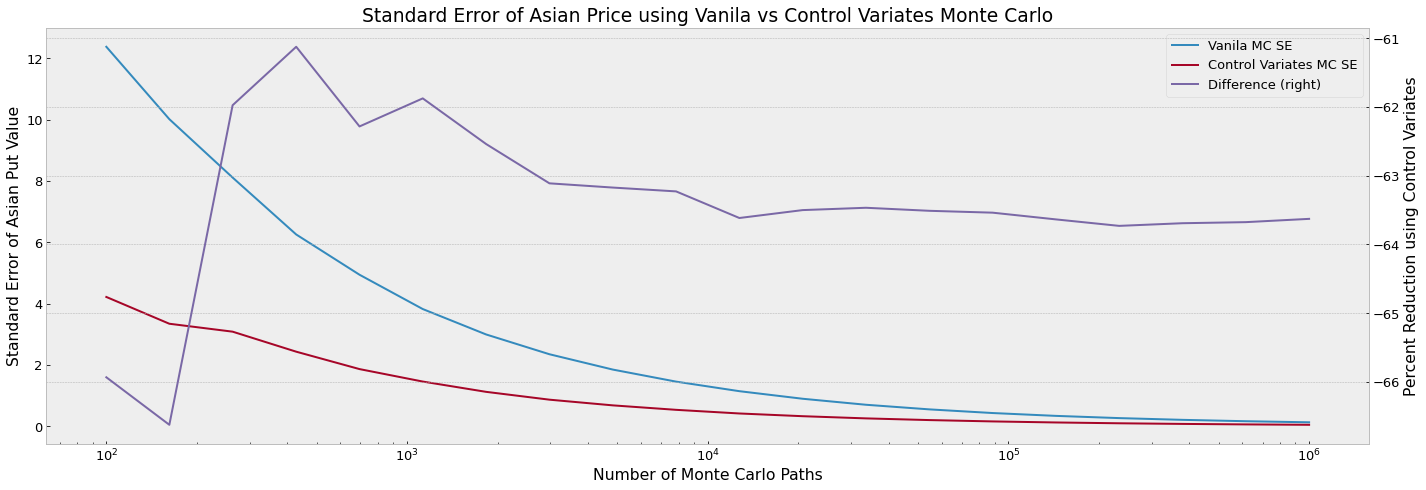

In [197]:
Ns = np.logspace(2, 6, num=20, base=10)

results = {}
for _N in tqdm(Ns):
    _N = int(_N)
    results[_N] = [asian_put_MC(S, K, r, sigma, T, _N, M)[1], asian_put_MC_CV(S, K, r, sigma, T, _N, M)[1]]

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Vanila MC SE', 'Control Variates MC SE'])
results_df['Difference'] = (results_df['Control Variates MC SE'] - results_df['Vanila MC SE'])/results_df['Vanila MC SE'] * 100
ax = results_df.plot(title='Standard Error of Asian Price using Vanila vs Control Variates Monte Carlo', secondary_y=['Difference'], logx=True,
                    xlabel='Number of Monte Carlo Paths', ylabel='Standard Error of Asian Put Value')
ax.right_ax.set_ylabel('Percent Reduction using Control Variates')
plt.tight_layout()

print(results_df.iloc[-1].to_string())

# Extra: Sobol MC - C Compiled Python numba
**Reduce variance of the estimation:**
- Sobol MC: Sobol’ sequences (also called LPτ sequences or (t, s) sequences in base 2) are an example of quasi-random low-discrepancy sequences
- **While Sobol by itself reduces variance. When used in combination with Control Variates it does not further reduce the variance of the approximation.**
    
**Reduce Computation time:**
- Numba: Just in time (JIT) Compiler allows python/numpy funcitons to be compiled to opimized C code before execution and cashed for future use. This speeds up sertain tasks 100-1000X times.


In [175]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

@njit
def asian_put_MC_CV(S0, K, r, sigma, T, N, M, X, analytical):
    Payoffs = np.empty(shape=(N,2))

    for m in range(N):
        St = S0 * np.exp(np.cumsum(X[m]))
        mean_St = np.mean((St[:-1] + St[1:])/2)

        """ 2 Step Asian Option """
        HT = np.cbrt(St[0] * St[int(M/2)]* St[-2])
        
        Payoffs[m, 0] = np.maximum(K - HT, 0)

        """ Asian Option """
        Payoffs[m, 1] =  np.maximum(K - mean_St, 0)

    Payoffs *= np.exp(-r*T)

    """ Calculating Control Variates """
    c = (np.cov(m=Payoffs[:, 1], y=Payoffs[:, 0])[0, 1])/Payoffs[:, 0].var() ;   # print(f'c = {c}')

    """ Adjusting Results Using Control Variates """
    Payoffs_adj = Payoffs[:,1] - c*(Payoffs[:, 0] - analytical)

    P   = Payoffs_adj.mean()
    SE  = Payoffs_adj.std() / np.sqrt(N)
    return P, SE

n_paths = ceil(np.log2(10**4)) ;   M = 100

analytical_2_step_asian = asian_2_step_put_analytical(S, K, r, sigma, T)
dt      = T/M

drift   = (r - 0.5*sigma**2)*dt
volatil = sigma*np.sqrt(dt)
W       = sobol_norm(n_paths, d=M, seed=1235)
X       = drift + volatil*W
X       = np.append(np.zeros((2**n_paths,1)), X, axis=1)

asian_CV_numerical_result, SE = asian_put_MC_CV(S, K, r, sigma, T, 2**n_paths, M, X, analytical_2_step_asian)

print(f'MC = {asian_CV_numerical_result:.3f} ,  Number of samples = {2**n_paths:,}')
print(f'SE = {SE:.3f}')
print(f'RE = {SE/asian_CV_numerical_result*100:.3f} %')
print(f'95% CI = [{asian_CV_numerical_result - SE*CI95:.3f} , {asian_CV_numerical_result + SE*CI95:.3f}]')
print(f'\nTime to calculate put Value using Monte Carlo')

%timeit asian_put_MC_CV(S, K, r, sigma, T, n_paths, M, X, analytical_2_step_asian)

MC = 115.546 ,  Number of samples = 16,384
SE = 0.359
RE = 0.310 %
95% CI = [114.843 , 116.249]

Time to calculate put Value using Monte Carlo
10.8 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Extra: Greeks

In [176]:
from importlib import reload
import Asian_Option_Pricing as ao
reload(ao)

AP = ao.Asian_Put_Option(S=S, K=K, T=10, r=r, sigma=sigma, N=10**5)
P0, SE = AP.get_price()
print(f'Price of Asian Put : {P0:.5f} USD')
print(f'Standard Error     : {SE:.5f} USD')
print('\n Greeks:\n------------------------')
print(f'Delta   : {AP.Delta :.5f}')
print(f'Vega    : {AP.Vega  :.3f}')
print(f'Theta   : {AP.Theta :.3f}')
print(f'Rho     : {AP.Rho :.3f}')
print(f'Gamma   : {AP.Gamma :.5f}')

Price of Asian Put : 115.14253 USD
Standard Error     : 0.36485 USD

 Greeks:
------------------------
Delta   : -0.45235
Vega    : 511.583
Theta   : 6.115
Rho     : -2647.479
Gamma   : 0.00166


In [206]:
100**2/30.6**2

10.679653124866503